# Temporal Anomaly Detection Dataset Challenge
Suppose our business is a pop-up store and relies on selling items to large groups of people.

We seek to make critical business decisions of where to locate our business based on anomalous activity on a certain pedestrian trail in Seattle. If there is an unusual amount of activity on the trail, we would like to relocate to the trail. Otherwise, we would find another location.

The dataset you will be using is collected by the City of Seattle using a combination of infrared and pressure sensors and consists of 5 features about the trail.

Your task is to create an anomaly detection model which can use these features to determine if the activity on the trail 3 hours in the future will be anomalous

#### Project specifications:
- Create an anomaly detection model to predict anomalies 3 hours in the future
- Provide clear visualizations to explain your results
- Consider experimental design choices for the results to be valid in production
- Describe how you would use these results to recommend an action to the business
- Please spend about 3 hours on this challenge
    - If you have extra time, please consider doing another investigation with the data that you think could help the business owners. This is completely optional and will only be used to kickstart our discussions of your work


<b>Definition of Anomalous</b>: The criteria for anomalous activity is at least 500 total people on the trail in the past
hour.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from typing import List

In [7]:
data_dir = "../data"
fname = "burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv"
data_fpath = os.path.join(data_dir, fname)

## Data Pre-Processing

In [9]:
def split_datetime_features(df:pd.DataFrame) -> pd.DataFrame:

    df['Date'] = pd.to_datetime(df['Date'])

    df['Ped Total'] = df['Ped North'] + df['Ped South']
    df['Bike Total'] = df['Bike North'] + df['Bike South']

    df['Day'] = df[ "Date"].dt.day
    df['Hour'] = df[ "Date"].dt.hour

    df['Day of Week'] = df[ "Date"].dt.dayofweek
    df['Month'] = df["Date"].dt.month
    df['Year'] = df[ "Date"].dt.year
    return df


def handle_missing_data(df:pd.DataFrame) -> pd.DataFrame:

    # Handle Null Data not in Gap
    df[df.Year.ne(2018)] = df[df.Year.ne(2018)].fillna(method="ffill")
    df[df.Year.ne(2018)] = df[df.Year.ne(2018)].fillna(method="bfill")
    df[df.Year.eq(2018) & df.Month.lt(6)] = df[df.Year.eq(2018) & df.Month.lt(6)].fillna(method='ffill')

    # Handle Null Data within Gap
    gap_min_month, gap_max_month = df[df.isna().any(axis=1)]['Month'].min(), df[df.isna().any(axis=1)]['Month'].max()
    df_null = df[df.isna().any(axis=1)]
    print(f"Gap Min Month: {gap_min_month}\nGap Max Month: {gap_max_month}")

    # TODO: optimize this algorithm
    for i, row in df_null.iterrows():
        metrics = {
            'BGT North of NE 70th Total': [],
            'Ped South': [],
            'Ped North': [],
            'Bike North': [],
            'Bike South': [],
            'Ped Total': [],
            'Bike Total':[]
        }
        missing_dt = row['Date']
        for year in df.Year.unique():
            if year == 2018: continue
            offset =  year - missing_dt.year
            curr_dt = missing_dt + pd.offsets.DateOffset(years=offset)
            curr_row = df[df.Date.eq(curr_dt)]
            if len(curr_row.index) != 1: continue
            for k, v in metrics.items(): metrics[k].append(curr_row[k].values[0])
            
        for k, v in metrics.items(): 
            mean_val = np.average(metrics[k])
            df.at[i, k] = float(round(mean_val))
    
    return df
    

def create_lags(df:pd.DataFrame, target_col:str, lag:int=3) -> pd.DataFrame:
    df["t"] = df[target_col]
    for i in range(lag): df[f"t-{i+1}"] = df[target_col].shift(i+1)
    return df


def preprocess(df:pd.DataFrame, target_col:str, lag:int=3) -> pd.DataFrame:
    df = split_datetime_features(df)
    df = handle_missing_data(df)

    df['BGT North of NE 70th Total'] = df['BGT North of NE 70th Total'].astype(np.int64)
    df['Ped South'] = df['Ped South'].astype(np.int64)
    df['Ped North'] = df['Ped North'].astype(np.int64)
    df['Bike North'] = df['Bike North'].astype(np.int64)
    df['Bike South'] = df['Bike South'].astype(np.int64)
    df['Ped Total'] = df['Ped Total'].astype(np.int64)
    df['Bike Total'] = df['Bike Total'].astype(np.int64)

    df = create_lags(df, target_col, lag=lag)

    df.dropna(inplace=True)
    for i in range(lag): df[f"t-{i+1}"] = df[f"t-{i+1}"].astype(np.int64)
    df.drop_duplicates(inplace=True)

    df.drop(columns=['Month', 'Year', 'Day of Week', 'Hour', 'Day', 'BGT North of NE 70th Total'], inplace=True)

    return df


In [4]:
def plot_features(
    df:pd.DataFrame, 
    index:str="Date", 
    features:List[str]=['Ped Total', 'Bike Total'],
    plot_type:str="line",
    xlim:tuple=None,
    ylim:tuple=None,
):
    """Function to plot features with respect to a given index

    Args:
        df (pd.DataFrame): data DataFrame
        index (str, optional): column to use as the x-axis. Defaults to "Date".
        features (List[str], optional): list of feature columns to use along y-axis. Defaults to ['Ped Total', 'Bike Total'].
        plot_type (str, optional): type of plot to create. Defaults to "line". See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
        xlim (tuple, optional): lmits on x-axis. Defaults to None.
        ylim (tuple, optional): limits on y-axis. Defaults to None.
    """
    colors = ['b','g', 'r']
    all_cols = [index] + features
    df_temp = df[all_cols]
    ax = None
    for i, feat in enumerate(features):
        ax = df_temp.plot(
            index, 
            feat, 
            kind=plot_type, 
            ax=ax, 
            label=feat, 
            color=colors[i],
            xlim=xlim,
            ylim=ylim
        )
        ax.set_xlabel(index)
        ax.set_ylabel("Counts")

In [10]:
df = pd.read_csv(data_fpath)
print(df.head())

df = preprocess(df, 'BGT North of NE 70th Total', lag=3)

df

                      Date  BGT North of NE 70th Total  Ped South  Ped North  \
0  2014-01-01T00:00:00.000                        15.0        0.0        2.0   
1  2014-01-01T01:00:00.000                         9.0        1.0        0.0   
2  2014-01-01T02:00:00.000                         9.0        0.0        0.0   
3  2014-01-01T03:00:00.000                        19.0        0.0        0.0   
4  2014-01-01T04:00:00.000                        19.0        0.0        0.0   

   Bike North  Bike South  
0         2.0        11.0  
1         1.0         7.0  
2         0.0         9.0  
3         0.0        19.0  
4         0.0        19.0  
Gap Min Month: 6
Gap Max Month: 9


,Date,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,t,t-1,t-2,t-3
3,2014-01-01 03:00:00,0,0,0,19,0,19,19,9,9,15
4,2014-01-01 04:00:00,0,0,0,19,0,19,19,19,9,9
5,2014-01-01 05:00:00,0,0,0,14,0,14,14,19,19,9
6,2014-01-01 06:00:00,0,1,1,8,1,9,10,14,19,19
7,2014-01-01 07:00:00,2,3,4,1,5,5,10,10,14,19
...,...,...,...,...,...,...,...,...,...,...,...
52579,2019-12-31 19:00:00,2,1,1,2,3,3,6,14,14,40
52580,2019-12-31 20:00:00,0,0,0,2,0,2,2,6,14,14
52581,2019-12-31 21:00:00,1,2,0,0,3,0,3,2,6,14
52582,2019-12-31 22:00:00,0,0,0,1,0,1,1,3,2,6


## Visualize Preprocessed Data

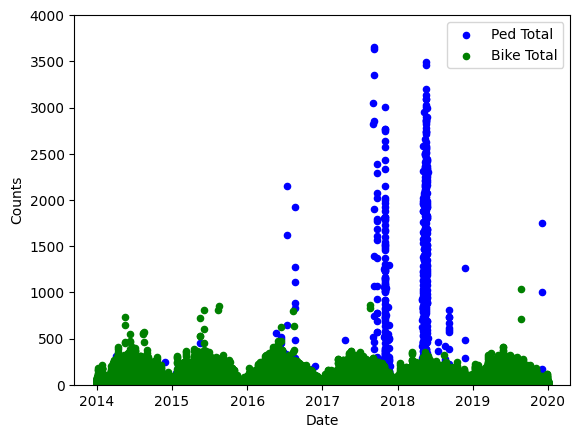

In [16]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter",
    ylim=(0, 4000)
)